In [1]:
#load file csv in ra tong so dong
df = spark.read.format("csv").option("header", "true").load("us-counties.csv")
df.show(5,False)
df.count()

+----------+-------+-------+-----+-----+------+---------------+----------------+--------------+---------------+
|date      |county |state  |fips |cases|deaths|confirmed_cases|confirmed_deaths|probable_cases|probable_deaths|
+----------+-------+-------+-----+-----+------+---------------+----------------+--------------+---------------+
|2020-06-22|Autauga|Alabama|01001|434  |9     |428            |8               |6             |1              |
|2020-06-22|Baldwin|Alabama|01003|430  |9     |415            |9               |15            |0              |
|2020-06-22|Barbour|Alabama|01005|272  |1     |271            |1               |1             |0              |
|2020-06-22|Bibb   |Alabama|01007|127  |1     |124            |1               |3             |0              |
|2020-06-22|Blount |Alabama|01009|149  |1     |146            |1               |3             |0              |
+----------+-------+-------+-----+-----+------+---------------+----------------+--------------+---------

3125

In [2]:
#xem cau truc cua dataframes
df.printSchema()

root
 |-- date: string (nullable = true)
 |-- county: string (nullable = true)
 |-- state: string (nullable = true)
 |-- fips: string (nullable = true)
 |-- cases: string (nullable = true)
 |-- deaths: string (nullable = true)
 |-- confirmed_cases: string (nullable = true)
 |-- confirmed_deaths: string (nullable = true)
 |-- probable_cases: string (nullable = true)
 |-- probable_deaths: string (nullable = true)



In [3]:
from pyspark.sql.types import *
#xoa tat ca cac dong = null
df = df.filter(df.cases.isNotNull())
df = df.filter(df.deaths.isNotNull())


#convert datatype
df = df.withColumn("cases",df['cases'].cast(IntegerType()))
df = df.withColumn("deaths",df['deaths'].cast(IntegerType()))

#xoa cac columns ko can thiet
columns_to_drop = ['date','county','state','fips','confirmed_cases','confirmed_deaths','probable_cases','probable_deaths']
df = df.drop(*columns_to_drop)
df.printSchema()
df.describe().show()
df.count()


root
 |-- cases: integer (nullable = true)
 |-- deaths: integer (nullable = true)

+-------+-----------------+-----------------+
|summary|            cases|           deaths|
+-------+-----------------+-----------------+
|  count|             3046|             3046|
|   mean|750.8381483913329|39.34504267892318|
| stddev|5069.217446406443|429.9272647690966|
|    min|                0|                0|
|    max|           217189|            21753|
+-------+-----------------+-----------------+



3046

In [4]:
df_main = df
from pyspark.sql import functions as F
#df_main = df_main.filter(df_main["deaths"] > 0)
df_main = df_main.filter(df_main["cases"] > 0)
#df_main = df_main.where((df_main["deaths"] /  df_main["cases"]) < 0.2)
df_main.show(10,False)
df_main.describe().show()


+-----+------+
|cases|deaths|
+-----+------+
|434  |9     |
|430  |9     |
|272  |1     |
|127  |1     |
|149  |1     |
|327  |10    |
|576  |26    |
|213  |4     |
|521  |27    |
|58   |6     |
+-----+------+
only showing top 10 rows

+-------+-----------------+-----------------+
|summary|            cases|           deaths|
+-------+-----------------+-----------------+
|  count|             3044|             3044|
|   mean|751.3314717477004|39.35840998685939|
| stddev|5070.846475604159|430.0681471936701|
|    min|                1|                0|
|    max|           217189|            21753|
+-------+-----------------+-----------------+



In [5]:
#chuyen total_cases sang dang vector
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
vectorAss = VectorAssembler(inputCols=["cases"], outputCol="features")
vectorAss = vectorAss.transform(df_main)
vectorAss.select('features','deaths').show(10,False)


+--------+------+
|features|deaths|
+--------+------+
|[434.0] |9     |
|[430.0] |9     |
|[272.0] |1     |
|[127.0] |1     |
|[149.0] |1     |
|[327.0] |10    |
|[576.0] |26    |
|[213.0] |4     |
|[521.0] |27    |
|[58.0]  |6     |
+--------+------+
only showing top 10 rows



In [6]:
final_data = vectorAss.select('features','deaths')
train_data,test_data = final_data.randomSplit([0.8,0.2])
train_data.describe().show()
final_data.show(10,False)

+-------+------------------+
|summary|            deaths|
+-------+------------------+
|  count|              2426|
|   mean| 42.16859027205276|
| stddev|476.16255131723625|
|    min|                 0|
|    max|             21753|
+-------+------------------+

+--------+------+
|features|deaths|
+--------+------+
|[434.0] |9     |
|[430.0] |9     |
|[272.0] |1     |
|[127.0] |1     |
|[149.0] |1     |
|[327.0] |10    |
|[576.0] |26    |
|[213.0] |4     |
|[521.0] |27    |
|[58.0]  |6     |
+--------+------+
only showing top 10 rows



In [7]:
test_data.describe().show()

+-------+------------------+
|summary|            deaths|
+-------+------------------+
|  count|               618|
|   mean|28.326860841423947|
| stddev|144.66502958427506|
|    min|                 0|
|    max|              2683|
+-------+------------------+



In [8]:
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics
ln = LinearRegression(maxIter=30, regParam=0.3, elasticNetParam=0.3, featuresCol='features', labelCol="deaths")
train_model = ln.fit(train_data)
result = train_model.evaluate(train_data)

print("intercept: ",train_model.intercept)
print("coefficient: ",train_model.coefficients)
print("Phuong sai trich dan: ", result.explainedVariance)
print("Sai so tuyet doi trung binh (MAE): ", result.meanAbsoluteError)
print("Sai so binh phuong trung binh (MSE): ", result.meanSquaredError)
print("Can cua sai so binh phuong trung binh (RMSE): ", result.rootMeanSquaredError)
print("R square: ",result.r2) #do chinh xac


intercept:  -22.066513146486635
coefficient:  [0.08207484591626872]
Phuong sai trich dan:  204623.78586262264
Sai so tuyet doi trung binh (MAE):  36.79159920613863
Sai so binh phuong trung binh (MSE):  21751.581104046934
Can cua sai so binh phuong trung binh (RMSE):  147.48417238485945
R square:  0.9040247147673968


In [9]:
#train_model.summary.predictions.show()
train_model.summary.predictions.registerTempTable("tasks")
a = sqlContext.sql("select * from tasks where prediction > 20");
a.show(10,False)

+--------+------+------------------+
|features|deaths|prediction        |
+--------+------+------------------+
|[514.0] |28.0  |20.119957654475485|
|[517.0] |70.0  |20.366182192224294|
|[519.0] |5.0   |20.530331884056828|
|[521.0] |27.0  |20.69448157588937 |
|[524.0] |37.0  |20.94070611363818 |
|[525.0] |2.0   |21.022780959554446|
|[526.0] |37.0  |21.104855805470713|
|[532.0] |9.0   |21.597304880968323|
|[532.0] |16.0  |21.597304880968323|
|[532.0] |49.0  |21.597304880968323|
+--------+------+------------------+
only showing top 10 rows



In [10]:
unLabel = test_data.select("features")
unLabel.show(10,False)
unLabel.columns

+--------+
|features|
+--------+
|[1.0]   |
|[1.0]   |
|[1.0]   |
|[1.0]   |
|[1.0]   |
|[1.0]   |
|[1.0]   |
|[1.0]   |
|[1.0]   |
|[1.0]   |
+--------+
only showing top 10 rows



['features']

In [11]:
prediction_unlabel = train_model.transform(unLabel)
prediction_unlabel.registerTempTable("tasks")
b = sqlContext.sql("select * from tasks where prediction > 20");
b.show(10,False)
prediction_unlabel.printSchema()

+--------+------------------+
|features|prediction        |
+--------+------------------+
|[514.0] |20.119957654475485|
|[516.0] |20.284107346308026|
|[525.0] |21.022780959554446|
|[525.0] |21.022780959554446|
|[530.0] |21.43315518913579 |
|[533.0] |21.67937972688459 |
|[555.0] |23.485026337042505|
|[566.0] |24.38784964212146 |
|[570.0] |24.716149025786535|
|[572.0] |24.880298717619077|
+--------+------------------+
only showing top 10 rows

root
 |-- features: vector (nullable = true)
 |-- prediction: double (nullable = false)



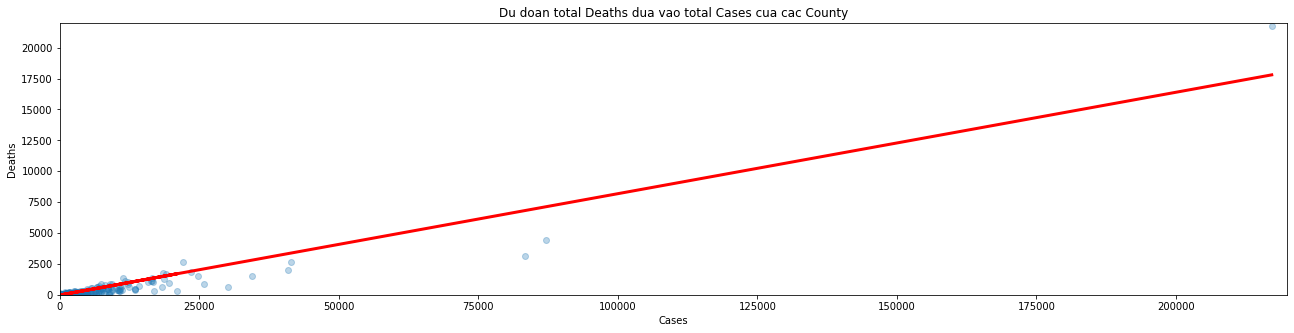

In [12]:
import matplotlib.pyplot as plt
import numpy as np

x = [int(row.cases) for row in df_main.select('cases').collect()]
y = [int(row.deaths) for row in df_main.select('deaths').collect()]

def convertVectorToArr(arr):
    arr_temp = [];
    for i in arr:
        arr_temp.append(int(i[0][0]))
    return arr_temp
#join bộ test và train
joindftrain = train_model.summary.predictions.drop("deaths")
joindf = prediction_unlabel.union(joindftrain)

#lay bo test_data.feature ("unLabel")
#convert vector sang kieu int 
arr = np.array(joindf.select('features').collect());
features_draw = convertVectorToArr(arr)

#du lieu dau ra y(total_deaths)=?
prediction_draw = [int(row.prediction) for row in joindf.select('prediction').collect()]
plt.figure(figsize=(22,5))
plt.scatter(x,y,alpha=0.3)
plt.plot(features_draw, prediction_draw,color="red",linewidth=3)
plt.title("Du doan total Deaths dua vao total Cases cua cac County")
plt.xlabel('Cases')
plt.ylabel('Deaths')
plt.xlim(0,220000)
plt.ylim(0,22000)
plt.show()